In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors


In [2]:
project_path = "/workspaces/bha2"
CONN_SIZE = 2165
SM_THRESH = 5
OPT_LEVEL = 28
OPT_GAMMA = 0.7
tree = json.loads(
                    open(
                        os.path.join(
                            project_path,
                            "data",
                            "processed",
                            "n" + str(CONN_SIZE),
                            "tree_g_" + str(OPT_GAMMA) + ".json",
                        )
                    ).read()
)
opt_level_modules, opt_level_labels = level_from_tree(tree, OPT_LEVEL)
opt_level_module_sizes = np.array([len(x) for x in opt_level_modules])

In [3]:

optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "optimal_parcellation.nii.gz",
    )
)
optimal_parcellation_data = optimal_parcellation.get_fdata()

In [4]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    # We define the brightness of a color, to avoid too bright colors
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
np.random.seed(3)
color_list = list(np.random.choice(color_list, OPT_LEVEL, replace=False))
# removing from the list colors corresponding to modules with less than SM_THRESH rois
color_list_ni = np.delete(color_list, np.where(opt_level_module_sizes < SM_THRESH)[0]).tolist()

/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


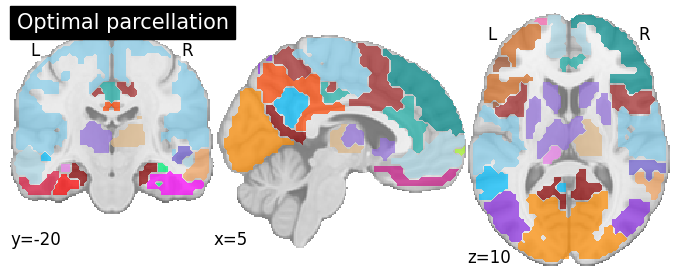

In [5]:
mni_bg = plotting.plot_anat(
    cut_coords=[5, -20, 10],
    black_bg=False,
    draw_cross=False,
    title="Optimal parcellation",
)

for module_idx in range(1, int(optimal_parcellation_data.max())+1):
    module_vol = np.zeros(
    (optimal_parcellation_data.shape[0], optimal_parcellation_data.shape[1], optimal_parcellation_data.shape[2])
    )
    module_vol[optimal_parcellation_data == module_idx] = 1
    module_img = nib.Nifti1Image(module_vol.astype(float), affine=optimal_parcellation.affine)
    mni_bg.add_contours(
            module_img, linewidths=2.0, levels=[0.01], filled=True, alpha=0.7, colors=color_list_ni[module_idx-1]
        )

plt.savefig(
    os.path.join(project_path, "data", "figures", "opt_parcell_brain.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

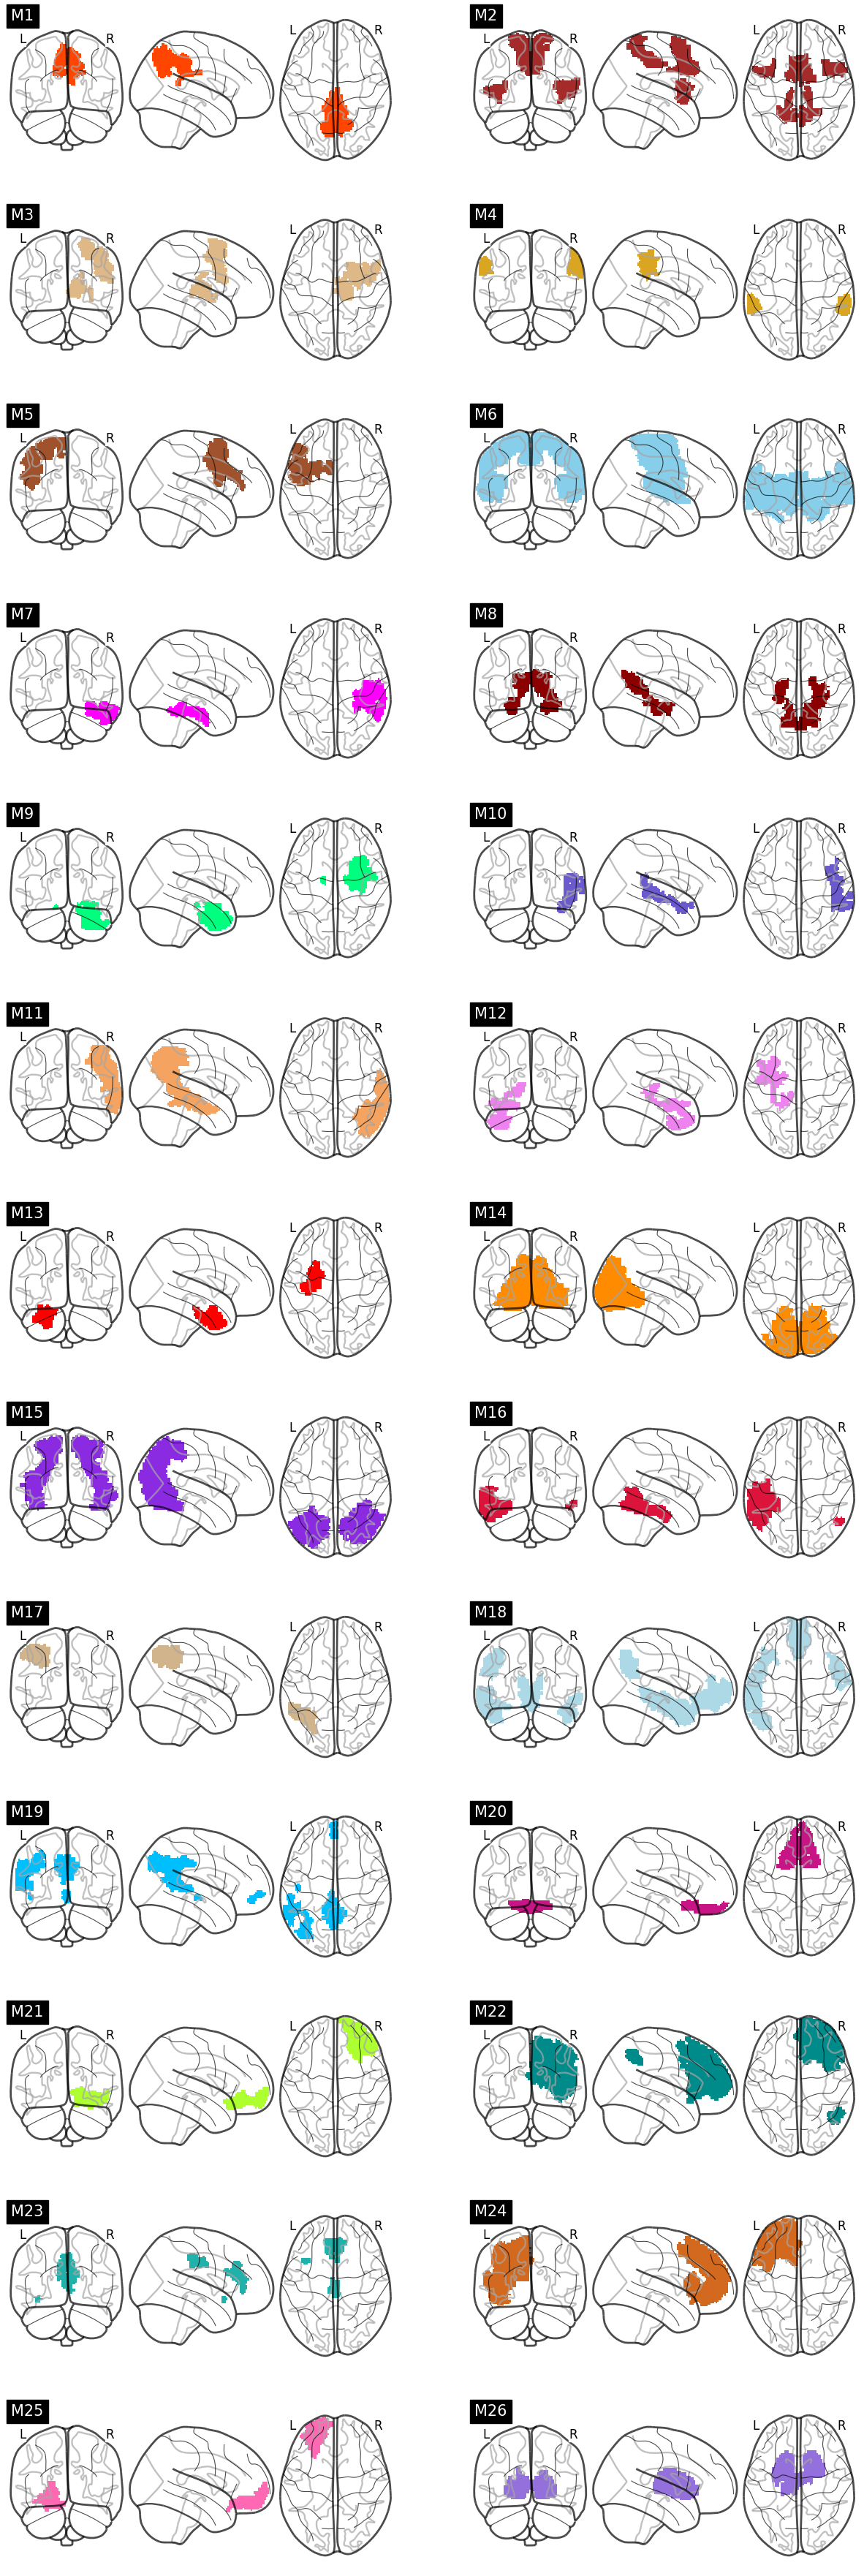

In [22]:
fig = plt.figure(figsize=(15,int((optimal_parcellation_data.max())/2 + 0.5)*3.5))

for module_idx in range(1, int(optimal_parcellation_data.max())+1):
    ax = fig.add_subplot(int((optimal_parcellation_data.max())/2 + 0.5), 2, module_idx)
    module_vol = np.zeros(
    (optimal_parcellation_data.shape[0], optimal_parcellation_data.shape[1], optimal_parcellation_data.shape[2])
    )
    module_vol[optimal_parcellation_data == module_idx] = 1
    module_img = nib.Nifti1Image(module_vol.astype(float), affine=optimal_parcellation.affine)
    plotting.plot_glass_brain(
            module_img,
            colorbar=False,
            cmap = colors.ListedColormap(color_list_ni[module_idx-1]),
            title="M" + str(module_idx),
            axes=ax,
        )

plt.savefig(
        os.path.join(project_path, "data", "figures", "optimal_parcellation_module_bglass.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )

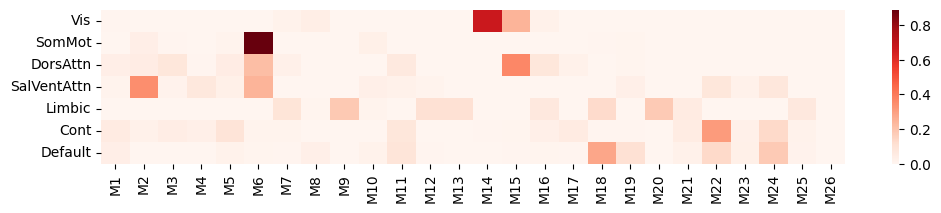

In [37]:
rsn = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.nii.gz")
)
rsn_vol = rsn.get_fdata()
rsn_vol_masked = rsn_vol * np.where(optimal_parcellation_data > 0, 1, 0)

rsn_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.txt"),
    dtype=str,
)


RSN_table = pd.DataFrame(
    columns=rsn_labels,
    index=np.array(["M" + str(i) for i in range(1, int(optimal_parcellation_data.max())+1)]),
    dtype=float,
)

for module_idx in range(1, int(optimal_parcellation_data.max())+1):
    module_vol = optimal_parcellation_data == module_idx
    rsn_count = np.zeros((int(rsn_vol_masked.max())))
    for i in range(1, int(rsn_vol_masked.max()) + 1):
        rsn_mask = np.where(rsn_vol_masked == i, 1, 0)
        rsn_count[i - 1] = (rsn_mask * module_vol).sum() / (rsn_mask.sum())
    RSN_table.loc["M" + str(module_idx)] = rsn_count

fig = plt.figure(figsize=(12,2))
sns.heatmap(pd.DataFrame.transpose(RSN_table), cmap="Reds", cbar=True)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "optimal_parcellation_RSNs.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

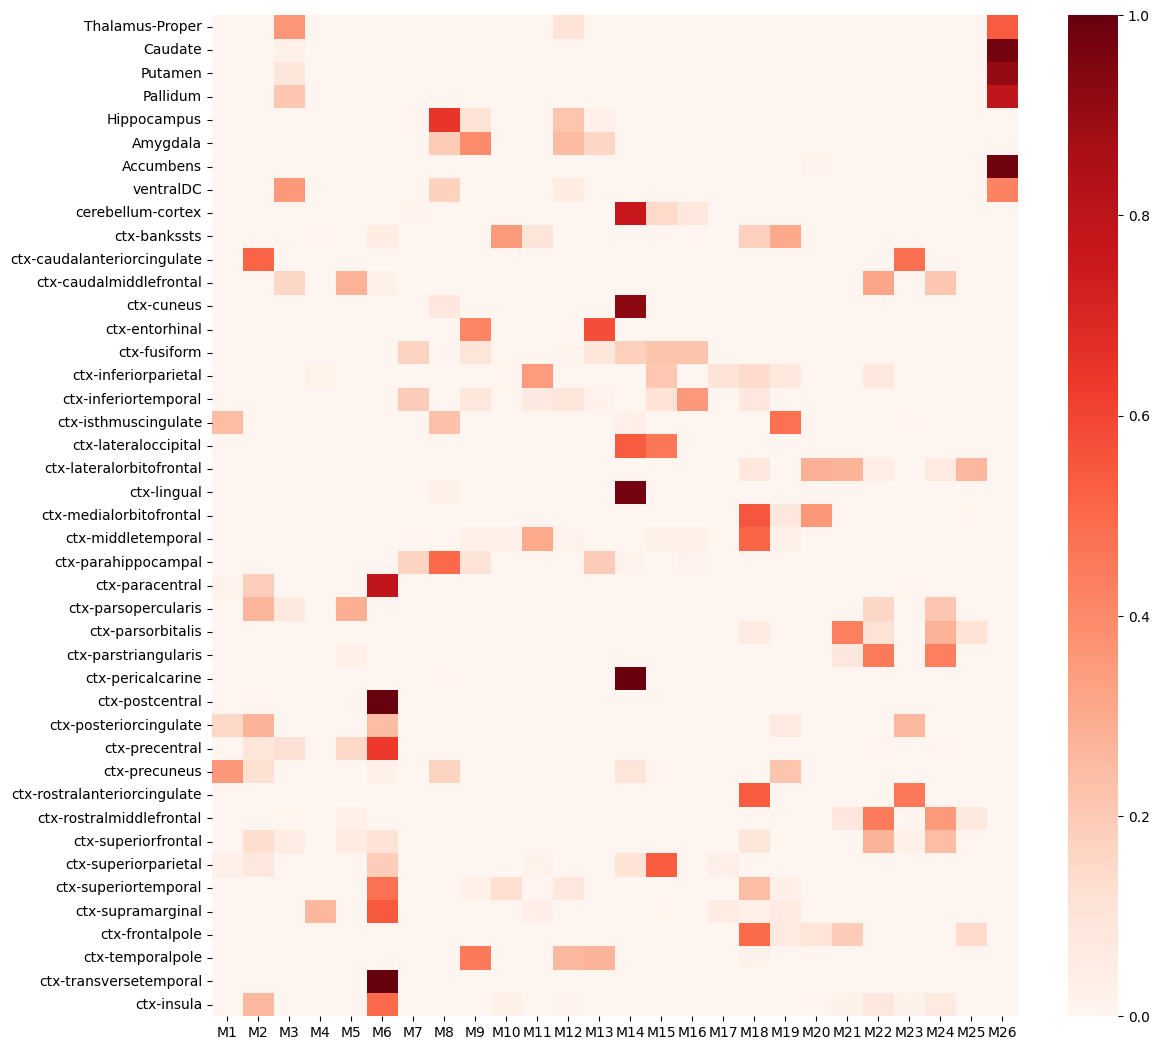

In [39]:
desikan = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany_bilateral.nii.gz")
)
desikan_vol = desikan.get_fdata()
desikan_vol_masked = desikan_vol * np.where(optimal_parcellation_data > 0, 1, 0)

desikan_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany_bilateral.txt"),
    dtype=str,
)

desikan_table = pd.DataFrame(
    columns=desikan_labels,
    index=np.array(["M" + str(i) for i in range(1, int(optimal_parcellation_data.max())+1)]),
    dtype=float,
)

for module_idx in range(1, int(optimal_parcellation_data.max())+1):
    module_vol = optimal_parcellation_data == module_idx
    desikan_count = np.zeros((int(desikan_vol_masked.max())))
    for i in range(1, int(desikan_vol_masked.max()) + 1):
        desikan_mask = np.where(desikan_vol_masked == i, 1, 0)
        desikan_count[i - 1] = (desikan_mask * module_vol).sum() / (
            desikan_mask.sum()
            )
    desikan_table.loc["M" + str(module_idx)] = desikan_count



fig = plt.figure(figsize=(13,13))
sns.heatmap(
    pd.DataFrame.transpose(desikan_table),
    cmap="Reds",
    cbar=True,
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "optimal_parcellation_anatomy_bilateral.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)